In [25]:
from pathlib import Path
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import numpy as np
import json
import typing as t
import scipy.stats
import warnings
import statsmodels.api as sm
import statsmodels.formula.api as smf

warnings.filterwarnings(action='ignore')
seaborn.set_style('whitegrid')

In [26]:
TRIALS_DIR = Path('../trials')
PLOTS_DIR = Path('./plots')
PLOTS_DIR.mkdir(exist_ok=True)
TABLES_DIR = Path('./tables')
TABLES_DIR.mkdir(exist_ok=True)
SITES = ('soldanesti_aval', 'soldanesti_amonte', 'saveni_aval', 'saveni_amonte')
MODELS = ('future', 'past')

In [49]:
class Model(t.TypedDict):
    estimated_dem: Path
    estimation_surface: Path


class Site(t.TypedDict):
    name: str
    future: Model
    past: Model


class Trial(t.TypedDict):
    config: dict[str, t.Any]
    sites: list[Site]


def parse_trial(path: Path) -> Trial:
    with (path / 'configs.json').open(mode='r') as file:
        config = json.load(file)
    trial = {'config': config}
    for site in SITES:
        site_path = path / site.upper()
        site_map = {'name': site}
        for model in MODELS:
            site_map[model] = {
                'estimated_dem': site_path
                / model.upper()
                / f'estimated_dem_{model}.tif',
                'estimation_surface': site_path
                / model.upper()
                / f'estimation_surface_output_{model}.fgb',
            }
        trial.setdefault('sites', []).append(site_map)
    return trial


def get_gdfs_from_trial(trial: Trial) -> dict[str, gpd.GeoDataFrame]:
    gdfs = []
    for site in trial['sites']:
        name = site['name']
        for model in MODELS:
            try:
                gdf = gpd.read_file(site[model]['estimation_surface'])
                gdf.columns = gdf.columns.str.rstrip('_sum')
                gdf[['model', 'site']] = [
                    'backcasting' if model == 'past' else 'forecasting',
                    name,
                ]
                for parameter, value in trial['config'].items():
                    if parameter in ('output_dir', 'id', 'trial_dir'):
                        continue
                    gdf[parameter] = value
                gdfs.append(gdf)
            except:
                print('Skipping', site[model]['estimation_surface'])
    return pd.concat(gdfs, ignore_index=True)


def smape(x, y):
    return 2 * np.abs(y - x) / (np.abs(y) + np.abs(x))


def prettify_column_names(gdf: gpd.GeoDataFrame):
    gdf['site'] = gdf['site'].map(
        {
            'soldanesti_aval': 'Șoldănești downstream',
            'soldanesti_amonte': 'Șoldănești upstream',
            'saveni_aval': 'Săveni downstream',
            'saveni_amonte': 'Săveni upstream',
        }
    )
    gdf = gdf.rename(columns={'changepoint_penalty': 'PELT penalty'})
    return gdf


trial_ids = {
    int(trial.name.split('_')[1]): trial
    for trial in list(TRIALS_DIR.glob('trial_*'))[:6]
    if trial.is_dir() and (trial / 'configs.json').exists()
}
trials = sorted(
    [parse_trial(trial_path) for trial_path in trial_ids.values()],
    key=lambda trial: trial['config']['id'],
)
trial_gdfs = pd.concat(
    [get_gdfs_from_trial(trial) for trial in trials], ignore_index=True
)

trial_gdfs['delta_SMAPE'] = (
    smape(trial_gdfs['delta_truth'], trial_gdfs['delta_estimated']) * 100
)
trial_gdfs['volume_SMAPE'] = (
    smape(trial_gdfs['volume_truth'], trial_gdfs['volume_estimated']) * 100
)
trial_gdfs = prettify_column_names(trial_gdfs)

In [54]:
smape(np.array([9.32]), np.array([4.92]))

array([0.61797753])

N=27
N=27


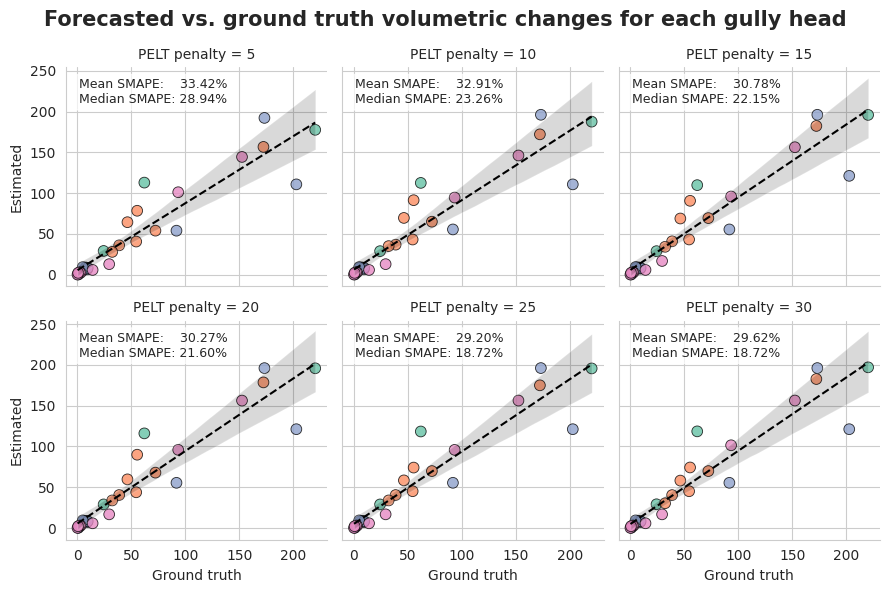

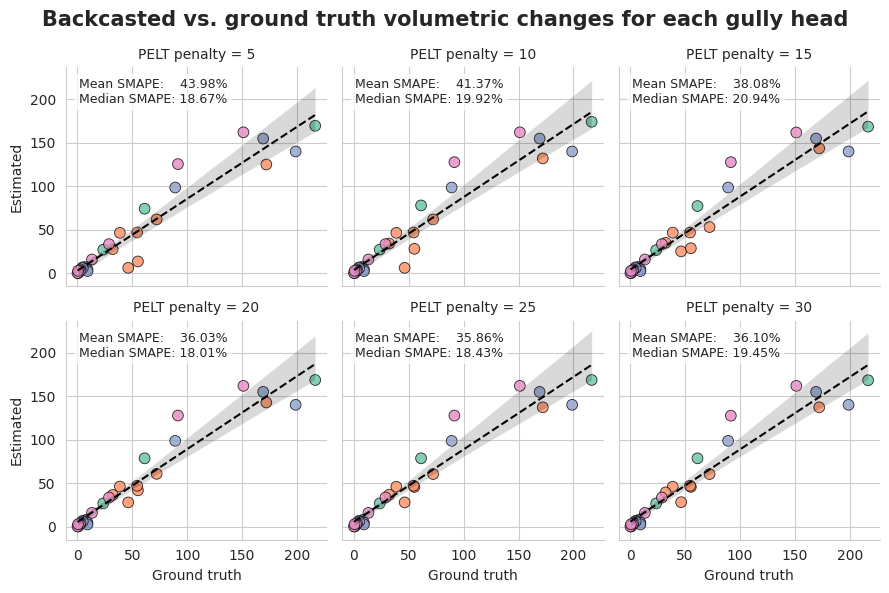

In [28]:
def plot_pelt_penalty(trial_gdfs, model, prefix, add_legend=True):
    gdf = trial_gdfs[trial_gdfs['model'] == model]
    gdf = gdf[
        [
            'PELT penalty',
            f'{prefix}_estimated',
            f'{prefix}_truth',
            f'{prefix}_SMAPE',
            'site',
            'geometry',
        ]
    ].rename(
        columns={
            f'{prefix}_estimated': 'Estimated volume',
            f'{prefix}_truth': 'Ground truth volume',
            f'{prefix}_SMAPE': 'SMAPE',
        }
    )
    print(f'N={gdf[gdf["PELT penalty"] == 5].dropna(subset="SMAPE").shape[0]}')
    g = seaborn.FacetGrid(gdf, col='PELT penalty', col_wrap=3)
    g.map_dataframe(
        seaborn.scatterplot,
        x='Ground truth volume',
        y='Estimated volume',
        hue='site',
        palette='Set2',
        edgecolor='black',
        s=60,
        alpha=0.8,
    )
    # Then optionally overlay regression line without hue
    g.map_dataframe(
        seaborn.regplot,
        x='Ground truth volume',
        y='Estimated volume',
        scatter=False,
        color='black',
        line_kws={'linewidth': 1.5, 'linestyle': 'dashed'},
    )

    for ax, (_, subdf) in zip(g.axes.flatten(), g.facet_data()):
        df_smape = subdf['SMAPE']
        area_mask = gdf.area > np.percentile(gdf.area, 5)
        df_smape_masked = df_smape[area_mask]
        mean_smape = df_smape_masked.mean()
        median_smape = df_smape_masked.median()
        ax.text(
            0.05,
            0.95,
            f'Mean SMAPE:    {mean_smape:.2f}%\nMedian SMAPE: {median_smape:.2f}%',
            transform=ax.transAxes,
            ha='left',
            va='top',
            fontsize=9,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7),
        )
    g.set_axis_labels(x_var='Ground truth', y_var='Estimated')

    # plt.suptitle(f'{model} {prefix}'.title())
    plt.suptitle(
        f'{"Forecasted" if model == "forecasting" else "Backcasted"} vs. ground truth volumetric changes for each gully head',
        size=15,
        weight='bold',
    )
    plt.tight_layout()
    if add_legend:
        g.add_legend(fontsize=15, ncol=4)


# plot_pelt_penalty(trial_gdfs, 'forecasting', 'volume')
# plot_pelt_penalty(trial_gdfs, 'backcasting', 'volume')
plot_pelt_penalty(trial_gdfs, 'forecasting', 'delta', add_legend=False)
plt.savefig(PLOTS_DIR / 'forecasted_vs_ground.png', dpi=300)
plot_pelt_penalty(trial_gdfs, 'backcasting', 'delta', add_legend=False)
plt.savefig(PLOTS_DIR / 'backcasted_vs_ground.png', dpi=300)

40.52780954917406


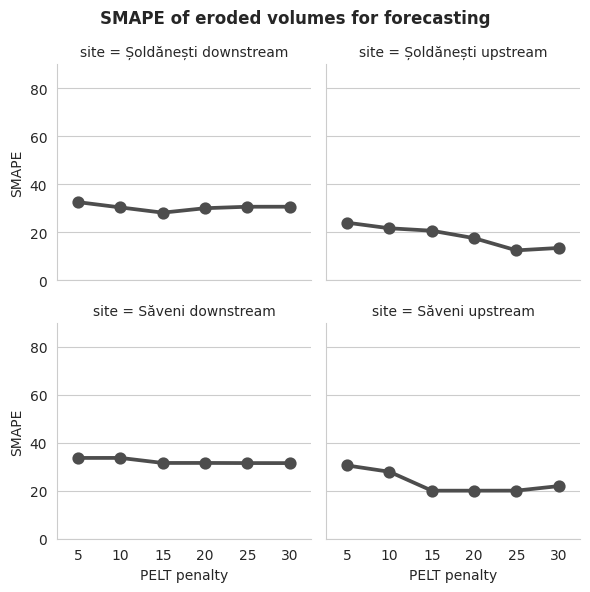

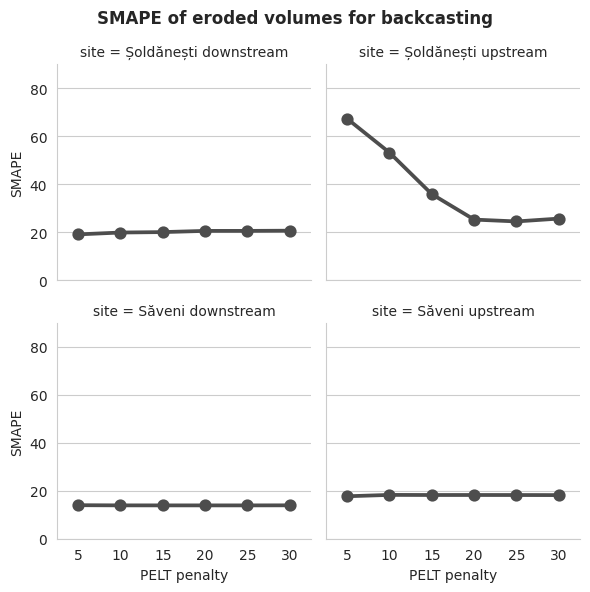

In [29]:
def print_site_error(
    trial_gdfs: gpd.GeoDataFrame,
    site: str,
    model: str,
    prefix: str,
):
    gdf_masked = trial_gdfs.loc[
        (trial_gdfs['model'] == model) & (trial_gdfs['site'] == site),
        [
            #    f'{prefix}_estimated',
            #    f'{prefix}_truth',
            'site',
            f'{prefix}_SMAPE',
            'PELT penalty',
        ],
    ].rename(columns={f'{prefix}_SMAPE': 'SMAPE'})
    grouped = gdf_masked.groupby(['site', 'PELT penalty']).mean()
    # y = grouped[f'{prefix}_estimated'].dropna()
    # x = grouped[f'{prefix}_truth'].dropna()
    # grouped['SMAPE'] = smape(x, y) * 100
    grouped['model'] = model
    return grouped


def plot_site_error(df: pd.DataFrame, model: str):
    df = df.reset_index()
    df = df[df['model'] == model]
    m = seaborn.FacetGrid(df, col_wrap=2, col='site', ylim=(0, 90))
    m.map(seaborn.pointplot, 'PELT penalty', 'SMAPE', color='.3')
    plt.suptitle(f'SMAPE of eroded volumes for {model}', weight='bold')
    plt.tight_layout()


gdfs = []
print(np.percentile(trial_gdfs.area, 50))
outlier_removed = trial_gdfs[
    trial_gdfs.area > np.percentile(trial_gdfs.area, 50)
]
for site in trial_gdfs['site'].unique():
    for model in ('forecasting', 'backcasting'):
        gdfs.append(
            print_site_error(
                outlier_removed,
                site,
                model,
                'delta',
            )
        )
gdf = pd.concat(gdfs)
plot_site_error(gdf, 'forecasting')
plot_site_error(gdf, 'backcasting')
# pd.set_option('display.max_rows', None)
# pd.concat(gdfs, ignore_index=False).head(80)

40.52780954917406


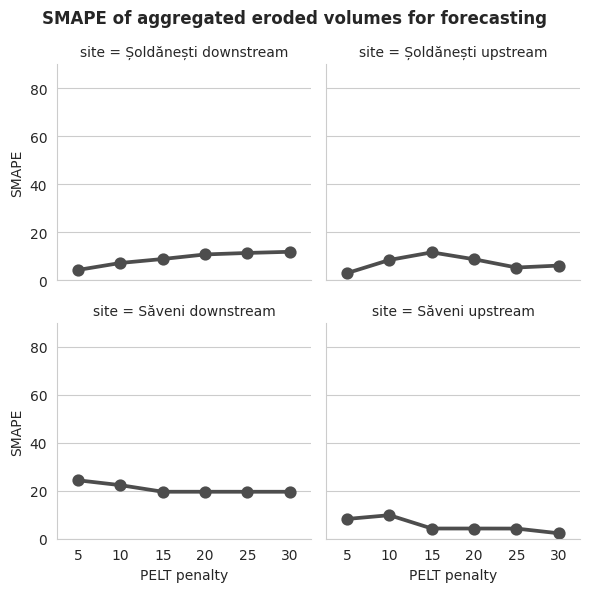

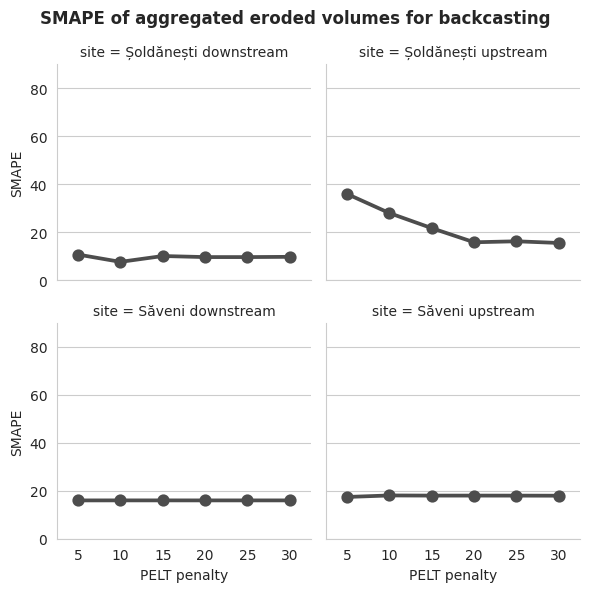

In [30]:
def print_site_error(
    trial_gdfs: gpd.GeoDataFrame,
    site: str,
    model: str,
    prefix: str,
):
    gdf_masked = trial_gdfs.loc[
        (trial_gdfs['model'] == model) & (trial_gdfs['site'] == site),
        [
            f'{prefix}_estimated',
            f'{prefix}_truth',
            'site',
            f'{prefix}_SMAPE',
            'PELT penalty',
        ],
    ].rename(columns={f'{prefix}_SMAPE': 'SMAPE'})
    grouped = gdf_masked.groupby(['site', 'PELT penalty']).sum()
    y = grouped[f'{prefix}_estimated'].dropna()
    x = grouped[f'{prefix}_truth'].dropna()
    grouped['SMAPE'] = smape(x, y) * 100
    grouped['model'] = model
    return grouped


def plot_site_error(df: pd.DataFrame, model: str):
    df = df.reset_index()
    df = df[df['model'] == model]
    m = seaborn.FacetGrid(df, col_wrap=2, col='site', ylim=(0, 90))
    m.map(seaborn.pointplot, 'PELT penalty', 'SMAPE', color='.3')
    plt.suptitle(
        f'SMAPE of aggregated eroded volumes for {model}', weight='bold'
    )
    plt.tight_layout()


gdfs = []
print(np.percentile(trial_gdfs.area, 50))
for site in trial_gdfs['site'].unique():
    for model in ('forecasting', 'backcasting'):
        gdfs.append(
            print_site_error(
                trial_gdfs,
                site,
                model,
                'delta',
            )
        )
gdf = pd.concat(gdfs)
plot_site_error(gdf, 'forecasting')
plot_site_error(gdf, 'backcasting')
# pd.set_option('display.max_rows', None)
#

In [31]:
def pair_sample_ttest(gdf: gpd.GeoDataFrame, model: str, prefix: str):
    masked = gdf.loc[gdf['model'] == model]
    for penalty in gdf['PELT penalty'].unique():
        penalty_masked = masked.loc[masked['PELT penalty'] == penalty,]
        residualds = (
            penalty_masked[f'{prefix}_truth']
            - penalty_masked[f'{prefix}_estimated']
        ).dropna()
        statistic, pvalue = scipy.stats.ttest_1samp(residualds, 0)
        penalty = int(penalty)
        print(f'{model=} {penalty=} {statistic=:.3f} {pvalue=:.5f}')


pair_sample_ttest(trial_gdfs, model='backcasting', prefix='delta')
print()
pair_sample_ttest(trial_gdfs, model='forecasting', prefix='delta')

model='backcasting' penalty=5 statistic=1.719 pvalue=0.09743
model='backcasting' penalty=10 statistic=1.454 pvalue=0.15791
model='backcasting' penalty=15 statistic=1.368 pvalue=0.18298
model='backcasting' penalty=20 statistic=1.156 pvalue=0.25809
model='backcasting' penalty=25 statistic=1.158 pvalue=0.25739
model='backcasting' penalty=30 statistic=1.130 pvalue=0.26893

model='forecasting' penalty=5 statistic=1.030 pvalue=0.31240
model='forecasting' penalty=10 statistic=0.501 pvalue=0.62062
model='forecasting' penalty=15 statistic=0.137 pvalue=0.89241
model='forecasting' penalty=20 statistic=0.208 pvalue=0.83657
model='forecasting' penalty=25 statistic=0.344 pvalue=0.73359
model='forecasting' penalty=30 statistic=0.245 pvalue=0.80828


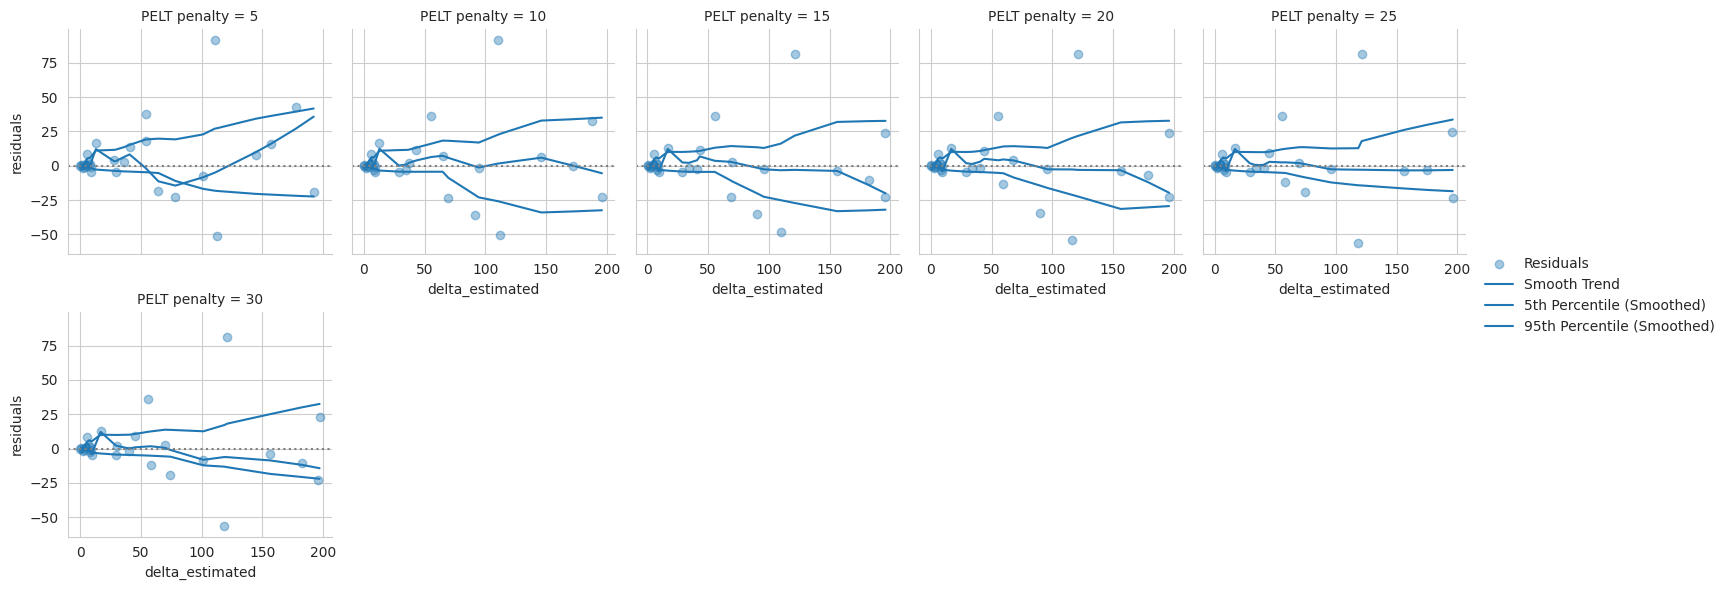

In [32]:
def heteroscedasticity_plot(gdf: gpd.GeoDataFrame, model: str, prefix: str):
    masked = gdf.loc[gdf['model'] == model]
    masked['residuals'] = (
        masked[f'{prefix}_truth'] - masked[f'{prefix}_estimated']
    )
    m = seaborn.FacetGrid(masked, col='PELT penalty', col_wrap=5)
    m.map(plot_residuals, f'{prefix}_estimated', 'residuals')
    m.add_legend()


# --- Helper function to plot residuals with smooth line and quantile bands ---
def smooth_quantiles(df, quantile=0.05, window=30):
    # Compute rolling quantiles with no center, to avoid NaNs at edges
    rolling_q = (
        df['res'].rolling(window=window, min_periods=1).quantile(quantile)
    )

    # Apply LOWESS smoothing to the rolling quantiles
    smoothed = sm.nonparametric.lowess(
        rolling_q, df['y_pred'], frac=0.3, return_sorted=False
    )
    return smoothed


def plot_residuals(y_pred, residuals, **kwargs):
    df = pd.DataFrame({'y_pred': y_pred, 'res': residuals}).sort_values(
        'y_pred'
    )

    lowess = sm.nonparametric.lowess
    smooth_line = lowess(df['res'], df['y_pred'], frac=0.3)

    # Smooth 5th and 95th percentiles
    q5_smooth = smooth_quantiles(df, 0.05, window=30)
    q95_smooth = smooth_quantiles(df, 0.95, window=30)

    # plt.figure(figsize=(10, 6))
    plt.scatter(df['y_pred'], df['res'], alpha=0.4, label='Residuals', **kwargs)
    plt.plot(
        smooth_line[:, 0],
        smooth_line[:, 1],
        # color='red',
        # linewidth=2,
        label='Smooth Trend',
        **kwargs,
    )
    plt.plot(
        df['y_pred'],
        q5_smooth,
        # color='blue',
        # linestyle='--',
        label='5th Percentile (Smoothed)',
        **kwargs,
    )
    plt.plot(
        df['y_pred'],
        q95_smooth,
        # color='blue',
        # linestyle='--',
        label='95th Percentile (Smoothed)',
        **kwargs,
    )
    plt.axhline(0, color='gray', linestyle=':')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.legend()
    plt.grid(True)


heteroscedasticity_plot(trial_gdfs, 'forecasting', 'delta')

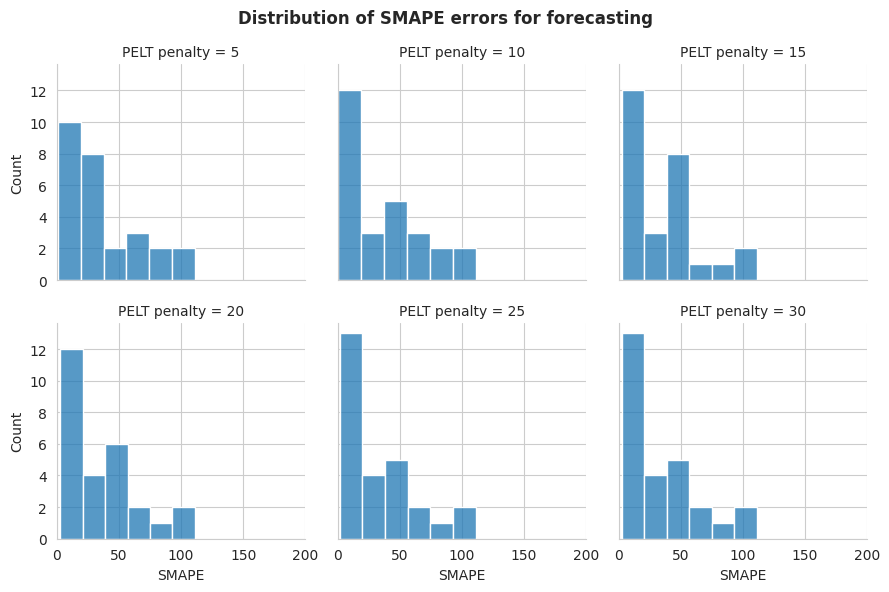

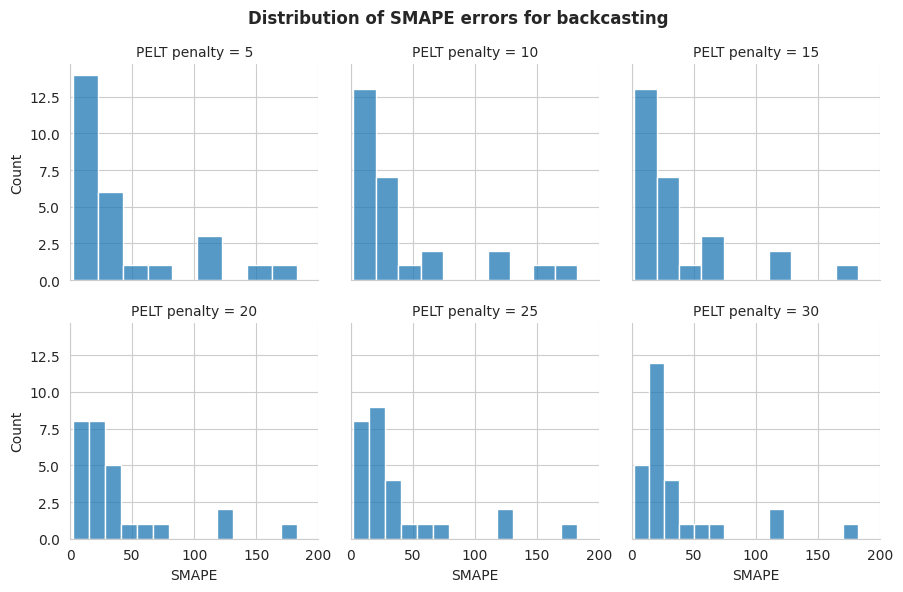

In [33]:
def histogram_error(gdf: gpd.GeoDataFrame, model: str, prefix: str):
    masked = gdf[
        (gdf['model'] == model)  # & (gdf.area > np.percentile(gdf.area, 25))
    ].rename(columns={'delta_SMAPE': 'SMAPE'})
    g = seaborn.FacetGrid(masked, col='PELT penalty', col_wrap=3, xlim=(0, 200))
    g.map(seaborn.histplot, 'SMAPE')
    plt.suptitle(f'Distribution of SMAPE errors for {model}', weight='bold')
    plt.tight_layout()


histogram_error(trial_gdfs, 'forecasting', 'delta')
histogram_error(trial_gdfs, 'backcasting', 'delta')

In [34]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2.0, n - 1)
    return m, m - h, m + h


def bootstrap_ci(data, metric_fn=np.mean, n_bootstrap=10000, ci=0.95):
    boot_samples = []
    n = len(data)

    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=n, replace=True)
        boot_samples.append(metric_fn(sample))

    return mean_confidence_interval(boot_samples, ci)


def ci(gdf: gpd.GeoDataFrame, model: str, prefix: str):
    mask = (gdf['model'] == model) & (gdf.area > np.percentile(gdf.area, 50))
    masked = gdf[mask]
    results = []
    for changepoint_penalty in masked['PELT penalty'].unique():
        penalty_masked = masked[masked['PELT penalty'] == changepoint_penalty]
        mean, lower, upper = bootstrap_ci(
            penalty_masked[f'{prefix}_SMAPE'].dropna()
        )
        changepoint_penalty = int(changepoint_penalty)
        lower = round(float(lower), 2)
        upper = round(float(upper), 2)
        mean = round(float(mean), 2)
        results.append(
            {
                'PELT penalty': changepoint_penalty,
                'mean SMAPE': f'{mean} [{lower}, {upper}]',
            }
        )
        print(
            f'{model=} {changepoint_penalty=} Confidence interval {lower=:.3f} - {mean=:.3f} - {upper=:.3f}'
        )
    return results


results_forecasting = ci(trial_gdfs, 'forecasting', 'delta')
results_backcasting = ci(trial_gdfs, 'backcasting', 'delta')
pd.DataFrame(results_forecasting).to_csv(
    TABLES_DIR / 'forecasting_errors_pelt.csv'
)
pd.DataFrame(results_backcasting).to_csv(
    TABLES_DIR / 'backcasting_errors_pelt.csv'
)

model='forecasting' changepoint_penalty=5 Confidence interval lower=29.400 - mean=29.510 - upper=29.630
model='forecasting' changepoint_penalty=10 Confidence interval lower=27.680 - mean=27.810 - upper=27.930
model='forecasting' changepoint_penalty=15 Confidence interval lower=24.820 - mean=24.930 - upper=25.030
model='forecasting' changepoint_penalty=20 Confidence interval lower=24.200 - mean=24.300 - upper=24.410
model='forecasting' changepoint_penalty=25 Confidence interval lower=22.590 - mean=22.690 - upper=22.800
model='forecasting' changepoint_penalty=30 Confidence interval lower=23.310 - mean=23.420 - upper=23.520
model='backcasting' changepoint_penalty=5 Confidence interval lower=33.490 - mean=33.700 - upper=33.910
model='backcasting' changepoint_penalty=10 Confidence interval lower=28.880 - mean=29.070 - upper=29.250
model='backcasting' changepoint_penalty=15 Confidence interval lower=23.250 - mean=23.340 - upper=23.430
model='backcasting' changepoint_penalty=20 Confidence int

In [40]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2.0, n - 1)
    return m, m - h, m + h


def bootstrap_ci(data, metric_fn=np.mean, n_bootstrap=10000, ci=0.95):
    boot_samples = []
    n = len(data)

    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=n, replace=True)
        boot_samples.append(metric_fn(sample))

    return mean_confidence_interval(boot_samples, ci)


def ci(gdf: gpd.GeoDataFrame, model: str, prefix: str, area_percentiles):
    mask = (gdf['model'] == model) & (gdf['PELT penalty'] == 20)
    masked = gdf[mask].dropna(subset=f'{prefix}_SMAPE')
    results = []
    for percentile in area_percentiles:
        area_cutoff = np.percentile(masked.area, percentile)
        percentile_masked = masked[masked.area >= area_cutoff]
        percentile_masked = percentile_masked.dropna(subset=f'{prefix}_SMAPE')
        mean, lower, upper = bootstrap_ci(percentile_masked[f'{prefix}_SMAPE'])
        lower = round(float(lower), 2)
        upper = round(float(upper), 2)
        mean = round(float(mean), 2)
        samples = percentile_masked.shape[0]
        results.append(
            {
                'Area Percentile Cutoff': percentile,
                'Area Cutoff': area_cutoff,
                'mean SMAPE': f'{mean} [{lower}, {upper}]',
                'samples': percentile_masked.shape[0],
            }
        )
        print(
            f'{model=} {percentile=} Confidence interval {lower=:.3f} - {mean=:.3f} - {upper=:.3f} {samples=}'
        )
    return results


percentiles = list(range(0, 91, 10))
results_forecasting = ci(trial_gdfs, 'forecasting', 'delta', percentiles)
results_backcasting = ci(trial_gdfs, 'backcasting', 'delta', percentiles)
pd.DataFrame(results_forecasting).to_csv(
    TABLES_DIR / 'forecasting_errors_area_cutoff.csv'
)
pd.DataFrame(results_backcasting).to_csv(
    TABLES_DIR / 'backcasting_errors_pelt_cutoff.csv'
)

model='forecasting' percentile=0 Confidence interval lower=34.120 - mean=34.240 - upper=34.350 samples=27
model='forecasting' percentile=10 Confidence interval lower=30.120 - mean=30.230 - upper=30.340 samples=24
model='forecasting' percentile=20 Confidence interval lower=28.030 - mean=28.140 - upper=28.240 samples=21
model='forecasting' percentile=30 Confidence interval lower=23.320 - mean=23.410 - upper=23.500 samples=19
model='forecasting' percentile=40 Confidence interval lower=24.030 - mean=24.130 - upper=24.230 samples=16
model='forecasting' percentile=50 Confidence interval lower=24.820 - mean=24.940 - upper=25.050 samples=14
model='forecasting' percentile=60 Confidence interval lower=24.430 - mean=24.560 - upper=24.690 samples=11
model='forecasting' percentile=70 Confidence interval lower=24.090 - mean=24.250 - upper=24.410 samples=8
model='forecasting' percentile=80 Confidence interval lower=30.980 - mean=31.160 - upper=31.340 samples=6
model='forecasting' percentile=90 Confid

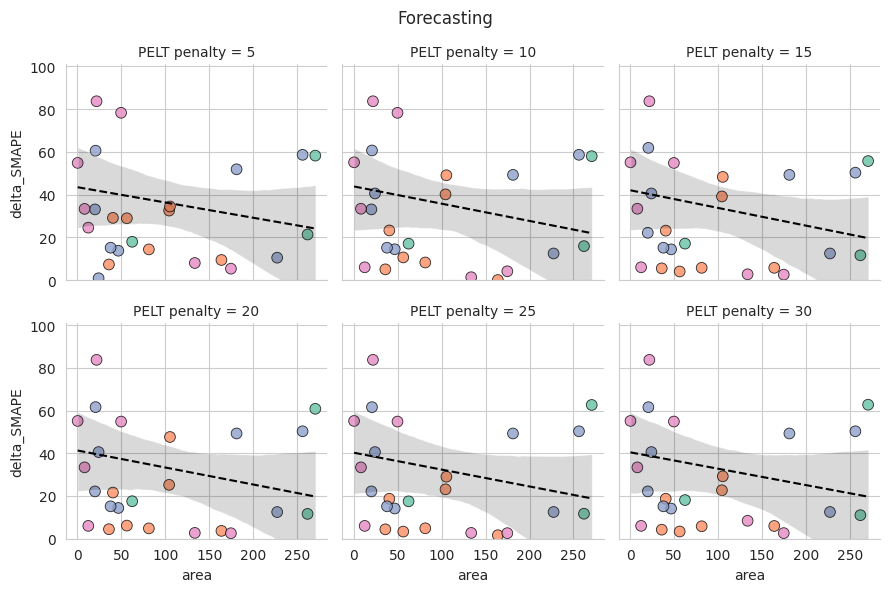

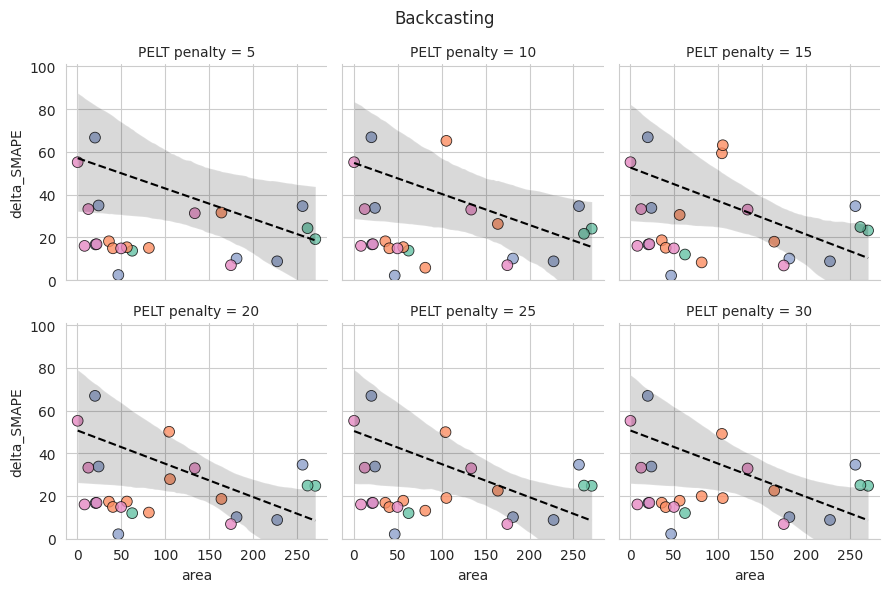

In [36]:
def smape_vs_area(gdf, model: str, prefix: str):
    masked = gdf[gdf['model'] == model]
    masked['area'] = masked.area
    g = seaborn.FacetGrid(masked, col_wrap=3, col='PELT penalty', ylim=(0, 101))
    g.map_dataframe(
        seaborn.scatterplot,
        x='area',
        y=f'{prefix}_SMAPE',
        hue='site',
        palette='Set2',
        edgecolor='black',
        s=60,
        alpha=0.8,
    )
    # Then optionally overlay regression line without hue
    g.map_dataframe(
        seaborn.regplot,
        x='area',
        y=f'{prefix}_SMAPE',
        scatter=False,
        color='black',
        line_kws={'linewidth': 1.5, 'linestyle': 'dashed'},
    )
    # g.set(
    #     yticks=np.arange(0, 2.25, 0.25),
    #     xlabel='Gully head area',
    #     ylabel='SMAPE',
    # )

    plt.suptitle(model.capitalize())
    plt.tight_layout()
    # g.add_legend()


smape_vs_area(trial_gdfs, 'forecasting', 'delta')
smape_vs_area(trial_gdfs, 'backcasting', 'delta')

In [37]:
def fit_error_to_area(gdf: gpd.GeoDataFrame, model: str, prefix: str):
    for penalty in gdf['PELT penalty'].unique():
        masked = gdf[
            (gdf['model'] == model) & (gdf['PELT penalty'] == penalty)
            # & (gdf.area > np.percentile(gdf.area, 0))
        ].dropna(subset=f'{prefix}_SMAPE')
        masked['area'] = masked.area
        smodel = f'area ~ {prefix}_SMAPE'
        smodel = smf.ols(formula=smodel, data=masked)
        results = smodel.fit()
        p_intercept, p_smape = results.pvalues
        penalty = int(penalty)
        print(f'{penalty=} {p_intercept=:.3f} {p_smape=:.3f}')


fit_error_to_area(trial_gdfs, 'forecasting', 'volume')
fit_error_to_area(trial_gdfs, 'backcasting', 'volume')

penalty=5 p_intercept=0.000 p_smape=0.118
penalty=10 p_intercept=0.000 p_smape=0.091
penalty=15 p_intercept=0.000 p_smape=0.070
penalty=20 p_intercept=0.000 p_smape=0.074
penalty=25 p_intercept=0.000 p_smape=0.070
penalty=30 p_intercept=0.000 p_smape=0.075
penalty=5 p_intercept=0.000 p_smape=0.114
penalty=10 p_intercept=0.000 p_smape=0.096
penalty=15 p_intercept=0.000 p_smape=0.070
penalty=20 p_intercept=0.000 p_smape=0.075
penalty=25 p_intercept=0.000 p_smape=0.075
penalty=30 p_intercept=0.000 p_smape=0.075


In [38]:
truth = pd.DataFrame.from_dict(
    {
        'Săveni downstream': [505.040221],
        'Săveni upstream': [295.127202],
        'Șoldănești downstream': [306.332691],
        'Șoldănești upstream': [471.437808],
    }
).T.rename(columns={0: 'delta_truth'})['delta_truth']
truth.index.name = 'site'


def get_aggregated_error(
    gdf: gpd.GeoDataFrame, model: str, prefix: str, pelt_penalty=20
):
    masked = gdf[
        (gdf['PELT penalty'] == pelt_penalty) & (gdf['model'] == model)
    ].drop(columns=['geometry'])
    aggregated = (
        masked[[f'{prefix}_estimated', f'{prefix}_truth', 'site']]
        .groupby('site')
        .sum()
    )
    aggregated[f'{prefix}_truth'] = truth
    aggregated['SMAPE'] = (
        smape(aggregated[f'{prefix}_truth'], aggregated[f'{prefix}_estimated'])
        * 100
    )

    return aggregated


pd.concat(
    [
        get_aggregated_error(
            trial_gdfs, model='backcasting', prefix='delta'
        ).add_prefix(prefix='backcast', axis='columns'),
        get_aggregated_error(trial_gdfs, model='forecasting', prefix='delta'),
    ],
    ignore_index=False,
    axis='columns',
).round(2)

,backcastdelta_estimated,backcastdelta_truth,backcastSMAPE,delta_estimated,delta_truth,SMAPE
site,,,,,,
Săveni downstream,420.61,505.04,18.24,414.90,505.04,19.60
Săveni upstream,348.16,295.13,16.49,282.83,295.13,4.26
Șoldănești downstream,273.81,306.33,11.21,340.97,306.33,10.70
Șoldănești upstream,402.18,471.44,15.86,514.27,471.44,8.69
